Stochastic SEIR with fomites, using DHL parcel data

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import Gillespie_package_SEIR as StochSim
import pandas as pd
import datetime as dt
import matplotlib
import seaborn as sns

matplotlib.rcParams.update({'font.size': 12})

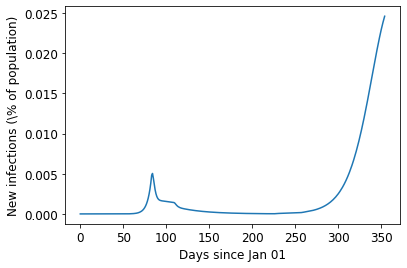

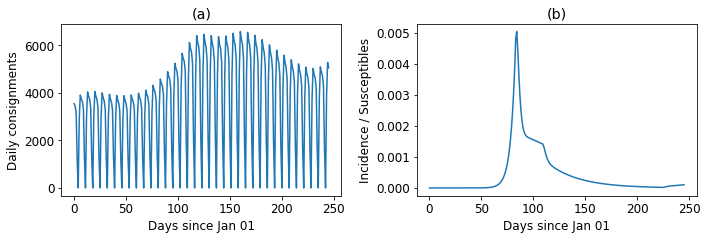

In [38]:
PrevData = pd.read_csv('UKPrevalence.csv')
Pdates = []
Pdelta = []
for d in PrevData['Date']:
    Pdates.append(dt.datetime.strptime(d,'%d/%m/%Y'))
    Pd = (Pdates[-1] - dt.datetime.strptime('01/01/20','%d/%m/%y'))
    Pdelta.append(Pd.days)
PrevData['DatePython'] = Pdates
PrevData['DateDelta'] = Pdelta
prevalence = np.append(np.zeros(PrevData['DateDelta'][0]),np.array(PrevData['incidence']))
cum_prev = np.append(np.zeros(PrevData['DateDelta'][0]),np.array(PrevData['cumulative incidence']))
UKpop0 = PrevData['cumulative incidence']/PrevData['cumulative fraction']
UKpop = np.append(np.ones(PrevData['DateDelta'][0])*UKpop0[0],UKpop0)
incidence = prevalence/UKpop
incidenceS = prevalence/(UKpop - cum_prev)
plt.plot(incidenceS)
plt.xlabel('Days since Jan 01')
plt.ylabel('New infections (\% of population)')


df = pd.read_pickle('DHL_parcel_demand.pkl')
nb1 = pd.read_pickle('Weekday_demand_fit_DHLP.pkl')
nb2 = pd.read_pickle('Site_demand_fit_DHLP.pkl')
nb3 = pd.read_pickle('Weekday_demand_driverfit_DHLP.pkl')

dc = float(nb1['Coeffs'][nb1['Params']=='DEMAND'])
Weekday = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
WDcoeffs0 = np.zeros(7)
for i in np.arange(7):
    for p in nb1['Params']:
        if Weekday[i] in p:
            WDcoeffs0[i] = nb1['Coeffs'][nb1['Params']==p]
demand = df['Demand'].to_numpy()
DOW = np.zeros(len(demand),dtype=np.int)
j = 0
for d in df['Dates']:
    dp = dt.datetime.strptime(d,'%d/%m/%y')
    DOW[j] = int(dp.weekday())
    j += 1
WDcoeffs = np.exp(WDcoeffs0)
WDcoeffs[6] = 0
mu = np.exp(float(nb1['Coeffs'][nb1['Params']=='Intercept']))*np.exp(dc*demand)*WDcoeffs[DOW]



site_coeffs = []
for p in nb2['Params']:
    if 'SITE' in p:
        site_coeffs.append(float(nb2['Coeffs'][nb2['Params']==p]))

mu_site = np.zeros((len(site_coeffs),len(mu)))
esc = np.exp(site_coeffs)
esc_sum = np.sum(esc)
overdisp = 0.02

occ = np.ones(len(mu))
occ[DOW==5] = 0.5
occ[DOW==6] = 0

avsite_demand = mu/52
fig,ax = plt.subplots(1,2,figsize=(10,3.5))
ax[0].plot(avsite_demand)
ax[1].plot(incidenceS[:len(mu)])
ax[0].set_xlabel('Days since Jan 01')
ax[1].set_xlabel('Days since Jan 01')
ax[0].set_ylabel('Daily consignments')
ax[1].set_ylabel('Incidence / Susceptibles')
ax[0].set_title('(a)')
ax[1].set_title('(b)')
fig.tight_layout()
fig.savefig('demand_inc.png')

In [45]:
site_coeffs = []
for p in nb2['Params']:
    if 'SITE' in p:
        site_coeffs.append(float(nb2['Coeffs'][nb2['Params']==p]))

mu_site = np.zeros((len(site_coeffs),len(mu)))
esc = np.exp(site_coeffs)
esc_sum = np.sum(esc)
overdisp = 0.02

print(np.sort(esc)*len(site_coeffs)/esc_sum)
occ = np.ones(len(mu))
occ[DOW==5] = 0.5
occ[DOW==6] = 0

[0.00346281 0.00564775 0.01038003 0.02597077 0.04247339 0.05399492
 0.07384839 0.08827112 0.1801676  0.22550274 0.26185543 0.3398487
 0.4814272  0.58270013 0.60732307 0.61021052 0.6428836  0.67392973
 0.75847466 0.76770586 0.88544095 0.90326252 0.95268372 0.97752761
 0.99668903 1.0035435  1.01269981 1.01684613 1.04022222 1.05585444
 1.0579548  1.07343648 1.07995409 1.1192471  1.12978849 1.14011754
 1.16588006 1.22035392 1.22562192 1.29212181 1.32526737 1.37871826
 1.39826197 1.40438153 1.42109774 1.42150491 1.43346942 1.48061481
 1.52959242 1.5705308  1.58340897 1.60242366 1.65888258 1.75409665
 1.89512107 1.96267371 2.07604648 2.13339105 2.18519203]


In [46]:
def stoch_repeats(Nrepeat, scales, NPmean, occ, incS, Ndays, Nf, gamma, sigma, SAR, \
                  wpcr, alphaT, alphaC, td, ccr, deliv_hlife, virus_hlife):
    FinalSize = np.zeros((len(scales)*Nrepeat*3))
    Size = np.zeros((len(scales)*Nrepeat*3))
    Pop = np.zeros((len(scales)*Nrepeat*3),dtype=np.int)
    j = 0
    for k in np.arange(len(scales)):
        print(k)
        N0 = Nf*scales[k]*3000/Nf[0]
        for n in np.arange(len(N0)):
            N0[n] = int(np.ceil(N0[n]))
        NP = np.zeros(Ndays)
        smu = scales[k]*NPmean
        for i in np.arange(Ndays):
            if NPmean[i] > 0:
                NP[i] = np.random.negative_binomial(1/overdisp,1-(smu[i]**2)*overdisp/(smu[i] + (smu[i]**2)*overdisp))  

        for n in np.arange(Nrepeat):
            Network1 = StochSim.SEIR_package_model_Gillespie(Ndays=Ndays, occupancy=occ, incidence_frac=incS,\
                                                         infection_probs=SAR, wp_contact_rate=[wpcr], td=td, alphaT=alphaT,\
                                                         alphaC=alphaC, sigma=sigma, gamma=gamma, cross_contact_rate = ccr,\
                                                         parcels_per_day=NP, del_hlife = deliv_hlife, virus_hlife=virus_hlife)
            t, S, E, I, P = Network1.run_sim(N0,N0.copy(),[0,0,0],[0,0,0],0,0)
            for k1 in np.arange(3):
                FinalSize[j] = N0[k1] - S[k1,-1]
                Size[j] = N0[k1]
                Pop[j] = k1
                j += 1
    Gnames = np.array(['Drivers','Loaders','Office'])
    df = pd.DataFrame({'Worplace size': Size, 'Group': Gnames[Pop], \
                       'Epidemic Size': FinalSize, 'Norm Epi Size': FinalSize/Size})
    return df

In [50]:
from multiprocessing import Pool
Nrepeat = 100
scales = esc/esc_sum
Ndays = len(mu)
Nf = np.array([50,15,10])/75
gamma = 1/3
sigma = 1/5
SAR = 0.05
td = 0.2
ccr = 1
d_hlife = 0.25
v_hlife = 0.1
alphas = [0.2,0.5]
wpcrs = [5,20]
args = []
for a in alphas:
    for w in wpcrs:
        args.append((Nrepeat,scales,mu,occ,incidenceS,Ndays,Nf,gamma,sigma,SAR,w,a,a,\
                    td,ccr,d_hlife,v_hlife))
#with Pool(4) as p:
#    output = p.starmap(stoch_repeats,args)
print(np.sort(scales*3000))
print(len(scales))

[  0.17607515   0.28717387   0.52779804   1.32054781   2.15966386
   2.74550458   3.75500279   4.48836204   9.16106441  11.46624121
  13.31468289  17.28044261  24.47934929  29.62881997  30.88083432
  31.0276537   32.68899667  34.26761349  38.56650814  39.03589112
  45.02242094  45.92860259  48.44154507  49.70479368  50.67910343
  51.02763563  51.49321087  51.70404056  52.89265538  53.68751375
  53.79431177  54.58151586  54.91291993  56.9108694   57.44687227
  57.97207827  59.28203694  62.05189403  62.31975864  65.70110888
  67.38647641  70.10431853  71.09806638  71.40923045  72.25920691
  72.27991062  72.88827566  75.28549857  77.77588557  79.85749817
  80.51232066  81.47916934  84.34996192  89.19135514  96.3620884
  99.79696819 105.5616852  108.47751079 111.11145924]
59


In [ ]:
fig,ax = plt.subplots(2,2,figsize=(10,6))
for i in np.arange(4)
    sns.boxplot(data=output[i], x='Group',y='Norm Epi Size',ax=ax[int(i/2),i%2])
    ax[int(i/2),i%2].set_title('Scenario %d' %(i+1))
fig.savefig('Scens_stochastic.png')

If probability of infection per unit t is constant there is a survival function exp(-lt)
and so infection probs is 1-exp(-lt) where t is duration of exposure

so if contact of 15 mins has probability 0.05, then l = -ln(0.95)/0.25
contact of 30 secs has probability...

In [ ]:
lam = -np.log(0.95)/0.25
print(1-np.exp(-lam/120))
print(1-np.exp(-3*lam))
print(1-np.exp(-8*lam))